In [13]:
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import pandas as pd
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd.functional import hessian
import torch.nn as nn
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_cropped_images(X, y, n):
    """Returns images that can be cropped by n pixels on all sides without
    losing any information (all cropped pixels = 0).

    Args:
        X np.ndarray: Input images.
        y np.ndarray: Corresponding labels.
        n (int): Number of pixels to crop from each side.

    Returns:
        np.ndarray: Cropped images.
    """

    mask = np.zeros((X.shape[1], X.shape[2]), dtype=bool)
    mask[:n, :] = True
    mask[-n:, :] = True
    mask[:, :n] = True
    mask[:, -n:] = True

    border_pixels = X[:, mask]
    croppable_mask = (border_pixels.sum(axis=1) == 0)
    return X[croppable_mask, n:-n, n:-n], y[croppable_mask]


In [4]:
# Preprocessing

# Load MNIST dataset
train = datasets.MNIST(root="./data", train=True,  download=True)
test  = datasets.MNIST(root="./data", train=False, download=True)
X_full = torch.cat([train.data, test.data], dim=0).numpy() / 255.0
y_full = torch.cat([train.targets, test.targets], dim=0).numpy()

# Crop images by n pixels on each side
X_cropped, y_cropped = get_cropped_images(X_full, y_full, 4)
y_cropped = pd.Series(y_cropped)

# Select most frequent classes
num_labels = 7
classes = y_cropped.value_counts().index[:num_labels]

# Create train/test split with 1000 train / 200 test samples per class
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for clss in classes:
    indices = y_cropped[y_cropped == clss].sample(1000, random_state=SEED).index
    X_train_list.append(X_cropped[indices[:800]])
    y_train_list.append(y_cropped[indices[:800]])
    X_test_list.append(X_cropped[indices[800:]])
    y_test_list.append(y_cropped[indices[800:]])

X_train = np.concatenate(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0).reset_index(drop=True)
X_test = np.concatenate(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0).reset_index(drop=True)

# Convert y from image label to class label (see classes variable)
class_map = {clss: idx for idx, clss in enumerate(classes)}
y_train = y_train.map(class_map)
y_test = y_test.map(class_map)

# Shuffle data
shuffle_indices_train = y_train.sample(y_train.shape[0], random_state=SEED).index
shuffle_indices_test = y_test.sample(y_test.shape[0], random_state=SEED).index

X = X_train[shuffle_indices_train]
y = y_train[shuffle_indices_train].reset_index(drop=True).to_numpy()
X_test = X_test[shuffle_indices_test]
y_test = y_test[shuffle_indices_test].reset_index(drop=True).to_numpy()

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.long, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [5]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, 
                 num_labels, activation):
        super(FullyConnectedNet, self).__init__()

        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layers_size = hidden_layer_size
        self.num_labels = num_labels
        self.activation = activation

        layers = [nn.Flatten()]
        in_size = input_size

        for _ in range(num_hidden_layers):
            layers += [nn.Linear(in_size, hidden_layer_size), activation()]
            in_size = hidden_layer_size

        layers.append(nn.Linear(in_size, num_labels))
        self.network = nn.Sequential(*layers)

            # --- Metadata for flatten/unflatten ---
        params = list(self.parameters())
        self.param_shapes = [p.shape for p in params]
        self.param_sizes  = [p.numel() for p in params]
        self.param_offsets = np.cumsum([0] + self.param_sizes).tolist()

    def forward(self, x):
        return self.network(x)

    def forward_with_params(self, X, flat_params):
        
        """Forward pass using explicit parameter vector."""
        params = self.unflatten_params(flat_params)
        x = X
        i = 0
        for layer in self.network:
            if isinstance(layer, nn.Flatten):
                x = x.view(x.size(0), -1)
            elif isinstance(layer, nn.Linear):
                w, b = params[i], params[i+1]
                x = F.linear(x, w, b)
                i += 2
            elif isinstance(layer, nn.ReLU):
                x = F.relu(x)
            else:
                raise ValueError(f"Unsupported layer type: {type(layer)}")
        return x

    def unflatten_params(self, flat_params):
        return [
            flat_params[self.param_offsets[i]:self.param_offsets[i+1]].view(self.param_shapes[i])
            for i in range(len(self.param_shapes))
        ]
        
    def flatten_params(self):
        return torch.cat([p.reshape(-1) for p in self.parameters()])

In [6]:
def loss_wrt_params(flat_params, model, criterion, X, y):
    """Compute scalar loss for explicit parameter vector."""
    outputs = model.forward_with_params(X, flat_params)
    return criterion(outputs, y)


def compute_hessian(model, criterion, X, y):
    """Compute full dense Hessian of loss wrt flattened parameters."""
    torch.cuda.empty_cache()
    params_flat = model.flatten_params().detach().clone().requires_grad_(True).to(X.device)
    return torch.autograd.functional.hessian(
        lambda p: loss_wrt_params(p, model, criterion, X, y),
        params_flat,
        vectorize=True
    )

def compute_eig_A(optimizer, H):
    v_t = torch.cat([
        state['square_avg'].flatten()
        for state in optimizer.state.values()
    ]).to(device)
    
    eta = optimizer.param_groups[0]['lr']
    eps = optimizer.param_groups[0]['eps']
    
    eta_eff = eta / torch.sqrt(v_t + eps)
    sqrt_eta = torch.sqrt(eta_eff)
    H_scaled = (H * sqrt_eta).T * sqrt_eta
    return torch.linalg.eigvalsh(H_scaled)  

In [7]:
def A_mv(v, model, X, y, D_sqrt):
    u = D_sqrt * v

    out = model(X)
    loss = criterion(out, y)
    grad = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    g_flat = torch.cat([p.reshape(-1) for p in grad])
    Hv = torch.autograd.grad(g_flat @ u, model.parameters())
    Hv_flat = torch.cat([h.reshape(-1) for h in Hv])

    return D_sqrt * Hv_flat

def top_eigenpair_A(model, optimizer, X, y, iters=50):
    v_t = torch.cat([state['square_avg'].flatten() for state in optimizer.state.values()])
    eta = optimizer.param_groups[0]['lr']
    eps = optimizer.param_groups[0]['eps']
    D_sqrt = torch.sqrt(eta / torch.sqrt(v_t + eps))
    
    v = torch.randn_like(D_sqrt)
    v = v / v.norm()

    for _ in range(iters):
        Av = A_mv(v, model, X, y, D_sqrt)
        v = Av / Av.norm()

    Av = A_mv(v, model, X, y, D_sqrt)
    lambda_max = (v @ Av).item()

    return lambda_max, v

In [8]:
input_size = X.shape[1] * X.shape[2] # 400
num_hidden_layers = 2
hidden_layer_size = 21
learning_rate = .01
epochs = 2000

model = FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=num_labels,
    activation=nn.ReLU
)

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

model.to(device)
model.train()

train_losses = np.empty(epochs)
eig_max_As = np.empty(epochs)

start = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    train_losses[epoch] = loss.item()
    eig_max_As[epoch] = top_eigenpair_A(model, optimizer, X, y)[0]
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Time: {round(((time.time() - start) / 60), 2)}")

np.save("train_losses.npy", train_losses)
np.save("eigenvalues_of_A.npy", eig_max_As)

Epoch [20/2000], Loss: 0.8022, Time: 0.08
Epoch [40/2000], Loss: 0.3845, Time: 0.17
Epoch [60/2000], Loss: 0.2678, Time: 0.26
Epoch [80/2000], Loss: 0.2052, Time: 0.34
Epoch [100/2000], Loss: 0.1794, Time: 0.42
Epoch [120/2000], Loss: 0.1595, Time: 0.5
Epoch [140/2000], Loss: 0.1469, Time: 0.59
Epoch [160/2000], Loss: 0.1321, Time: 0.67
Epoch [180/2000], Loss: 0.2142, Time: 0.75
Epoch [200/2000], Loss: 0.1677, Time: 0.83
Epoch [220/2000], Loss: 0.1065, Time: 0.92
Epoch [240/2000], Loss: 0.1013, Time: 1.0
Epoch [260/2000], Loss: 0.0886, Time: 1.09
Epoch [280/2000], Loss: 0.0771, Time: 1.17
Epoch [300/2000], Loss: 0.0716, Time: 1.25
Epoch [320/2000], Loss: 0.0994, Time: 1.31
Epoch [340/2000], Loss: 0.0593, Time: 1.37
Epoch [360/2000], Loss: 0.8570, Time: 1.43
Epoch [380/2000], Loss: 0.0595, Time: 1.49
Epoch [400/2000], Loss: 0.0539, Time: 1.56
Epoch [420/2000], Loss: 0.1030, Time: 1.62
Epoch [440/2000], Loss: 0.0563, Time: 1.68
Epoch [460/2000], Loss: 0.0461, Time: 1.74
Epoch [480/2000],

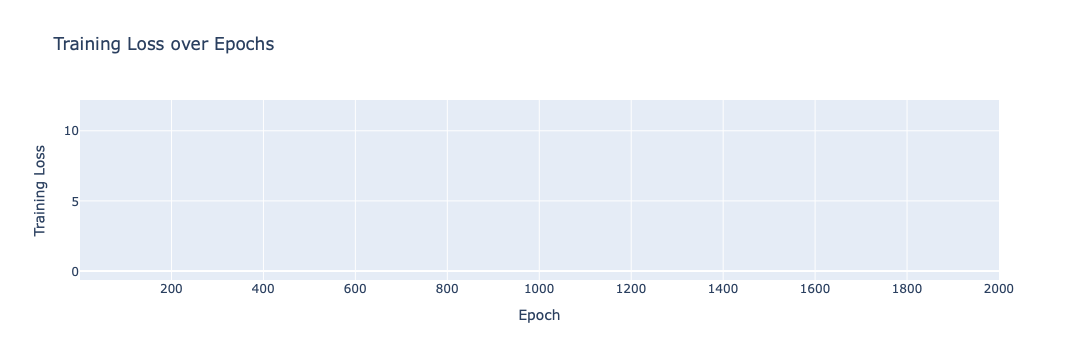

In [34]:
px.line(x=np.arange(1, epochs+1), y=train_losses,
           labels={'x': 'Epoch', 'y': 'Training Loss'},
           title='Training Loss over Epochs').show()

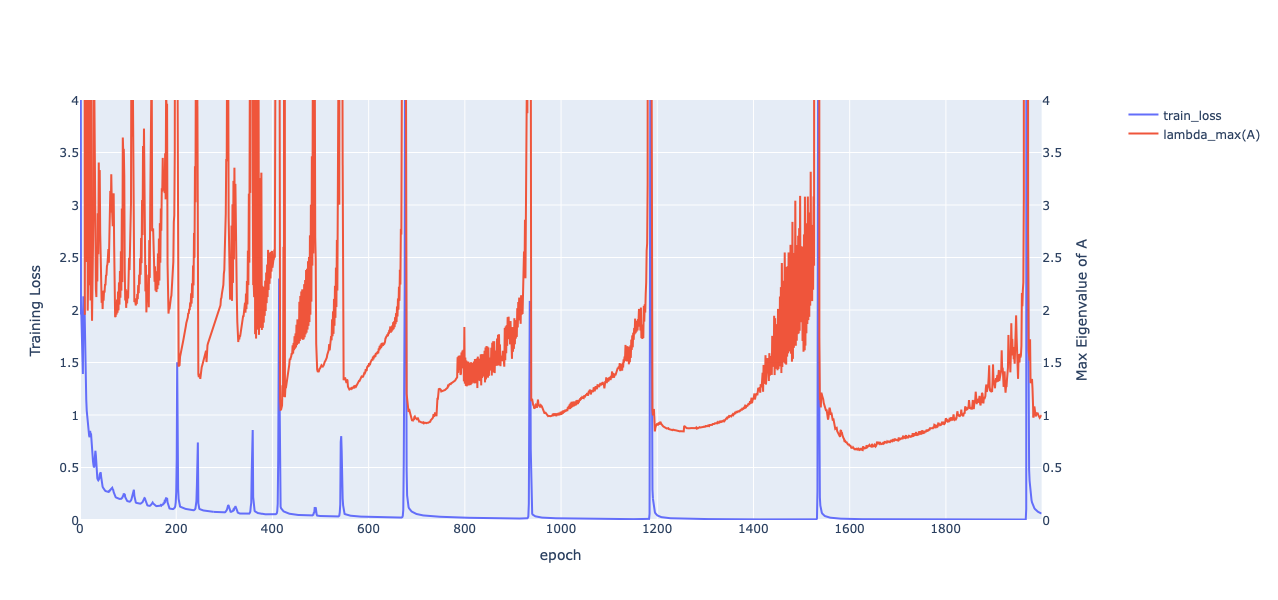

In [42]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

xs = np.arange(epochs)

# Left y-axis
fig.add_trace(
    go.Scatter(x=xs, y=train_losses, name="train_loss",line=dict(width=2)),
    secondary_y=False
)

# Right y-axis
fig.add_trace(
    go.Scatter(x=xs, y=eig_max_As, name="lambda_max(A)", line=dict(width=2)),
    secondary_y=True
)

# Axis labels
fig.update_yaxes(title_text="Training Loss", secondary_y=False, range = [0,4], showgrid=False)
fig.update_yaxes(title_text="Max Eigenvalue of A", secondary_y=True, range = [0,4])
fig.update_xaxes(title_text="epoch")
fig.update_layout(height = 600, width = 1400)

fig.show()

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    preds = outputs.argmax(dim=1)
    correct = (preds == y_test.to(device)).sum().item()
    accuracy = correct / len(y_test)

print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
times.mean()

In [167]:
2000*times.mean() / 60 / 60

3.005106806755066

In [16]:
eig_A_all.max(axis=1)[:100]

array([1054.76599121,  304.07540894,   87.2572403 ,    9.01186466,
         23.54054832,    8.1423521 ,  158.62062073,   11.27026463,
         14.20119572,    9.30966282,    1.95407414,    2.68802571,
          5.58377218,   11.01514912,    2.45703292,   13.95366001,
          1.99380839,    2.28465772,    2.23548388,    4.66636515,
          2.58486414,    3.88145614,    2.09085774,    7.92504072,
          2.25892758,    1.89733279,    2.25295925,    2.57431221,
          2.94777131,    4.49576044,    3.75456882,    4.10919094,
          2.51304412,    2.20016861,    2.12335968,    2.55492759,
          2.27205253,    2.92117906,    2.53124046,    3.40454745,
          2.84564519,    3.3325541 ,    2.73156261,    2.40325832,
          2.34064007,    2.06846666,    2.18386173,    2.00909257,
          2.16093111,    2.088974  ,    2.18489003,    2.16639471,
          2.24027538,    2.24175215,    2.32782888,    2.33294821,
          2.41855693,    2.4348793 ,    2.50249481,    2.58035

In [24]:
((eig_A_all > 2).mean(axis = 1) * 100)[:100]

array([1.00697134, 0.40942791, 0.15491867, 0.04426248, 0.15491867,
       0.0553281 , 0.27664048, 0.0553281 , 0.07745933, 0.02213124,
       0.        , 0.01106562, 0.01106562, 0.02213124, 0.01106562,
       0.03319686, 0.        , 0.01106562, 0.01106562, 0.02213124,
       0.01106562, 0.02213124, 0.01106562, 0.02213124, 0.01106562,
       0.        , 0.01106562, 0.01106562, 0.02213124, 0.01106562,
       0.02213124, 0.02213124, 0.01106562, 0.01106562, 0.01106562,
       0.01106562, 0.01106562, 0.01106562, 0.02213124, 0.01106562,
       0.02213124, 0.01106562, 0.02213124, 0.01106562, 0.01106562,
       0.01106562, 0.01106562, 0.01106562, 0.01106562, 0.01106562,
       0.01106562, 0.01106562, 0.02213124, 0.01106562, 0.02213124,
       0.01106562, 0.02213124, 0.01106562, 0.03319686, 0.01106562,
       0.03319686, 0.01106562, 0.03319686, 0.02213124, 0.03319686,
       0.02213124, 0.03319686, 0.02213124, 0.02213124, 0.02213124,
       0.02213124, 0.01106562, 0.01106562, 0.        , 0.     